In [1]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import os
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 3 * 64 * 64)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = self.relu(self.bn1(self.fc1(z)))
        z = self.relu(self.bn2(self.fc2(z)))
        z = self.relu(self.bn3(self.fc3(z)))
        z = self.tanh(self.fc4(z))
        z = z.view(-1, 3, 64, 64)  # Reshape into image (3 channels, 64x64)
        return z

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(256 * 8 * 8, 1)
        self.relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.sigmoid(self.fc1(x))
        return x

In [3]:
# Định nghĩa transform để chuẩn hóa và resize ảnh
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize ảnh về 64x64
    transforms.ToTensor(),        # Chuyển ảnh thành tensor
    transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa giá trị ảnh về [-1, 1]
])

class MultiDataset(Dataset):
    def __init__(self, dataset_dirs, transform=None):
        """
        dataset_dirs: Danh sách các thư mục chứa ảnh.
        transform: Các phép biến đổi ảnh.
        """
        self.image_paths = []
        self.transform = transform

        # Lấy tất cả đường dẫn ảnh từ các thư mục
        for dataset_dir in dataset_dirs:
            for img_file in os.listdir(dataset_dir):
                if img_file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                    self.image_paths.append(os.path.join(dataset_dir, img_file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Đảm bảo ảnh có 3 kênh (RGB)
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
# Đường dẫn đến các thư mục ảnh
dataset_dirs = ['./GAN_data/rem_face/rem_preprocessed_512', './GAN_data/anime_faces/anime_face/images', './GAN_data/anime_face/face/data']

# Khởi tạo Dataset và DataLoader
multi_dataset = MultiDataset(dataset_dirs, transform=transform)
dataloader = DataLoader(multi_dataset, batch_size=64, shuffle=True)


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [6]:
import matplotlib.pyplot as plt

def show_generated_images(generator, epoch, device):
    """
    Hiển thị 9 hình ảnh sinh ra từ Generator trên lưới 3x3.
    """
    generator.eval()  # Chuyển Generator sang chế độ đánh giá (eval)
    with torch.no_grad():
        z = torch.randn(9, 100).to(device)  # Tạo 9 vector latent ngẫu nhiên
        fake_images = generator(z).cpu()  # Sinh ra hình ảnh giả từ Generator
        fake_images = fake_images.permute(0, 2, 3, 1)  # Đổi thứ tự để hiển thị (N, H, W, C)
        fake_images = (fake_images + 1) / 2  # Chuẩn hóa giá trị ảnh về [0, 1]

    # Vẽ ảnh trên lưới 3x3
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Tạo lưới 3x3
    fig.suptitle(f'Generated Images at Epoch {epoch}', fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(fake_images[i].numpy())  # Hiển thị ảnh
        ax.axis('off')  # Tắt trục tọa độ

    plt.show()
    generator.train()  # Quay lại chế độ huấn luyện (train)


In [7]:
# Ví dụ về quá trình huấn luyện và hiển thị
def train_gan(num_epochs, dataloader, generator, discriminator, optimizer_G, optimizer_D, criterion, device):
    for epoch in range(num_epochs):
        for i, real_images in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Tạo nhãn thật và giả
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Huấn luyện Discriminator
            optimizer_D.zero_grad()

            # Đánh giá ảnh thật
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)

            # Tạo ảnh giả
            z = torch.randn(batch_size, 100).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Huấn luyện Generator
            optimizer_G.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

        
        if epoch % 10 == 0:  # Hiển thị sau mỗi 10 epoch
            show_generated_images(generator, epoch, device)

Epoch [0/100], D Loss: 0.6534707546234131, G Loss: 2.6784658432006836


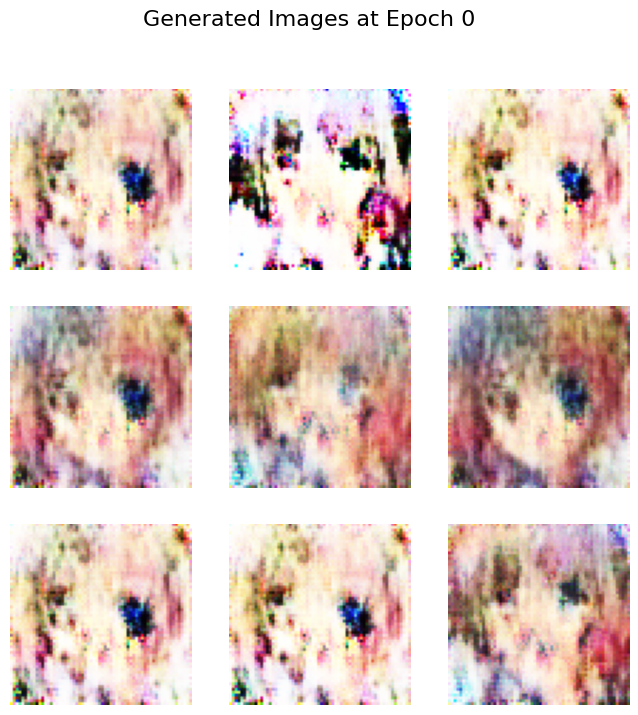

Epoch [1/100], D Loss: 0.6996241807937622, G Loss: 2.864184856414795
Epoch [2/100], D Loss: 0.4797372817993164, G Loss: 2.6818618774414062
Epoch [3/100], D Loss: 0.4665987193584442, G Loss: 2.7496697902679443
Epoch [4/100], D Loss: 0.6492365598678589, G Loss: 2.1522939205169678
Epoch [5/100], D Loss: 0.5491026043891907, G Loss: 1.9186769723892212
Epoch [6/100], D Loss: 0.6395577192306519, G Loss: 2.402282238006592
Epoch [7/100], D Loss: 0.5446691513061523, G Loss: 2.964130163192749
Epoch [8/100], D Loss: 0.3152288496494293, G Loss: 3.034698486328125
Epoch [9/100], D Loss: 0.3452235460281372, G Loss: 2.7571794986724854
Epoch [10/100], D Loss: 0.4775974154472351, G Loss: 2.232351779937744


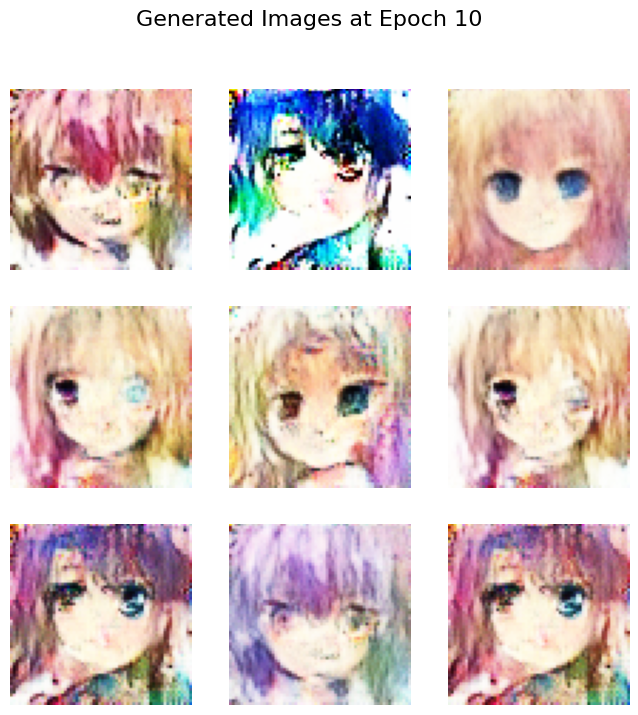

Epoch [11/100], D Loss: 0.41198137402534485, G Loss: 1.9421467781066895
Epoch [12/100], D Loss: 0.344561904668808, G Loss: 3.020648956298828
Epoch [13/100], D Loss: 0.5148239731788635, G Loss: 2.762033462524414
Epoch [14/100], D Loss: 0.38863301277160645, G Loss: 2.66372013092041
Epoch [15/100], D Loss: 1.1184970140457153, G Loss: 5.683357238769531
Epoch [16/100], D Loss: 0.5543991327285767, G Loss: 1.3645431995391846
Epoch [17/100], D Loss: 0.1631094217300415, G Loss: 3.7689576148986816
Epoch [18/100], D Loss: 0.43466803431510925, G Loss: 3.116680860519409
Epoch [19/100], D Loss: 0.5130322575569153, G Loss: 2.3971853256225586
Epoch [20/100], D Loss: 0.4678230285644531, G Loss: 6.803710460662842


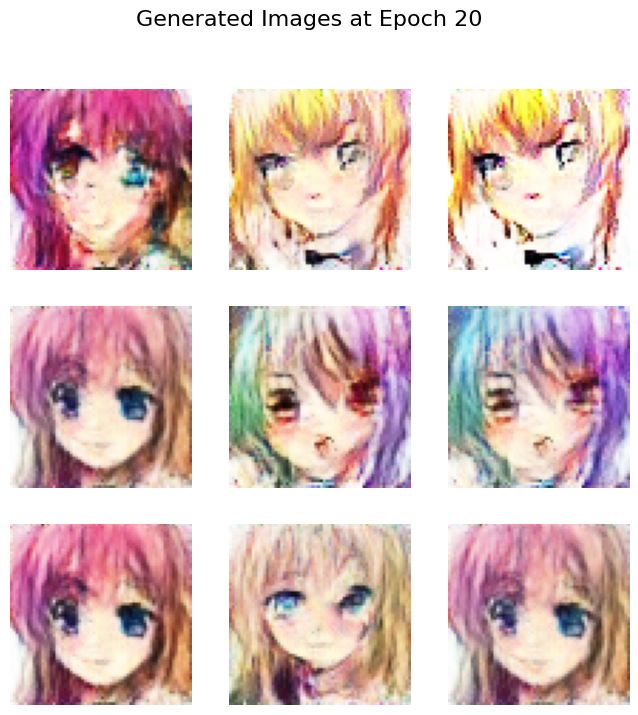

Epoch [21/100], D Loss: 0.4449414312839508, G Loss: 2.5277421474456787
Epoch [22/100], D Loss: 0.5627200603485107, G Loss: 3.088367462158203
Epoch [23/100], D Loss: 0.09432987123727798, G Loss: 4.360085487365723
Epoch [24/100], D Loss: 0.7649500370025635, G Loss: 1.906695008277893
Epoch [25/100], D Loss: 0.11997710168361664, G Loss: 4.34907865524292
Epoch [26/100], D Loss: 0.5161161422729492, G Loss: 9.568655967712402
Epoch [27/100], D Loss: 0.11631155014038086, G Loss: 3.454583168029785
Epoch [28/100], D Loss: 0.07916505634784698, G Loss: 5.010268211364746
Epoch [29/100], D Loss: 0.3262733817100525, G Loss: 3.098078966140747
Epoch [30/100], D Loss: 0.16140398383140564, G Loss: 4.289445400238037


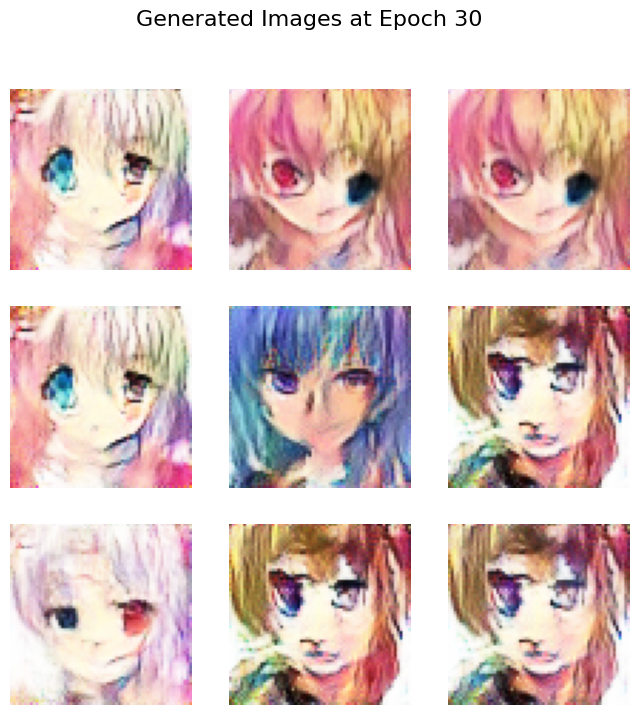

Epoch [31/100], D Loss: 0.29960519075393677, G Loss: 7.264062881469727
Epoch [32/100], D Loss: 0.7388545274734497, G Loss: 1.1431636810302734
Epoch [33/100], D Loss: 0.05769091844558716, G Loss: 4.9700236320495605
Epoch [34/100], D Loss: 0.034090396016836166, G Loss: 4.687530517578125
Epoch [35/100], D Loss: 0.19034670293331146, G Loss: 5.162265777587891
Epoch [36/100], D Loss: 0.42251265048980713, G Loss: 5.2379326820373535
Epoch [37/100], D Loss: 0.08996929973363876, G Loss: 4.376030445098877
Epoch [38/100], D Loss: 0.4182679057121277, G Loss: 3.7859389781951904
Epoch [39/100], D Loss: 0.1606442630290985, G Loss: 3.1471288204193115
Epoch [40/100], D Loss: 0.21358883380889893, G Loss: 4.148256778717041


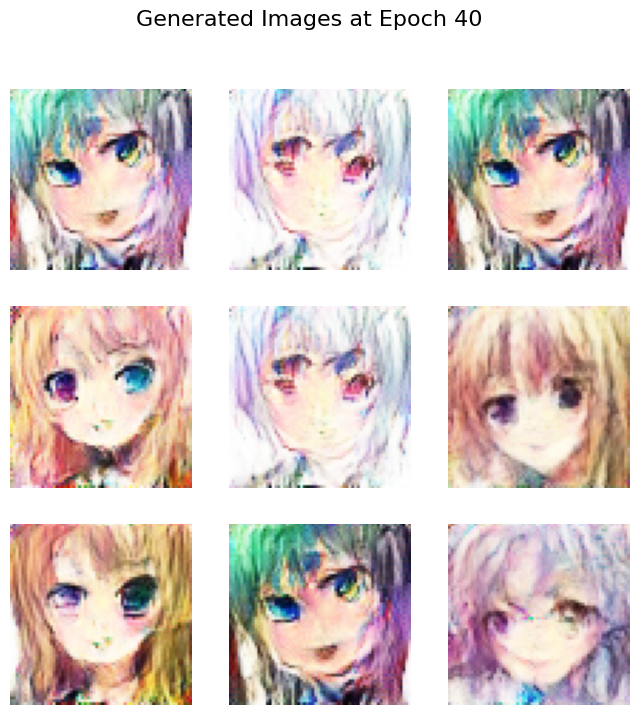

Epoch [41/100], D Loss: 0.08588812500238419, G Loss: 5.422482013702393
Epoch [42/100], D Loss: 0.2147780805826187, G Loss: 6.009077072143555
Epoch [43/100], D Loss: 0.08273712545633316, G Loss: 5.887321949005127
Epoch [44/100], D Loss: 0.21240341663360596, G Loss: 6.461666584014893
Epoch [45/100], D Loss: 0.0980115756392479, G Loss: 3.4564859867095947
Epoch [46/100], D Loss: 0.35934144258499146, G Loss: 4.137073993682861
Epoch [47/100], D Loss: 0.3643952012062073, G Loss: 3.3119089603424072
Epoch [48/100], D Loss: 0.05472744628787041, G Loss: 4.891557693481445
Epoch [49/100], D Loss: 0.08094282448291779, G Loss: 4.586792469024658
Epoch [50/100], D Loss: 0.3712676763534546, G Loss: 10.48067569732666


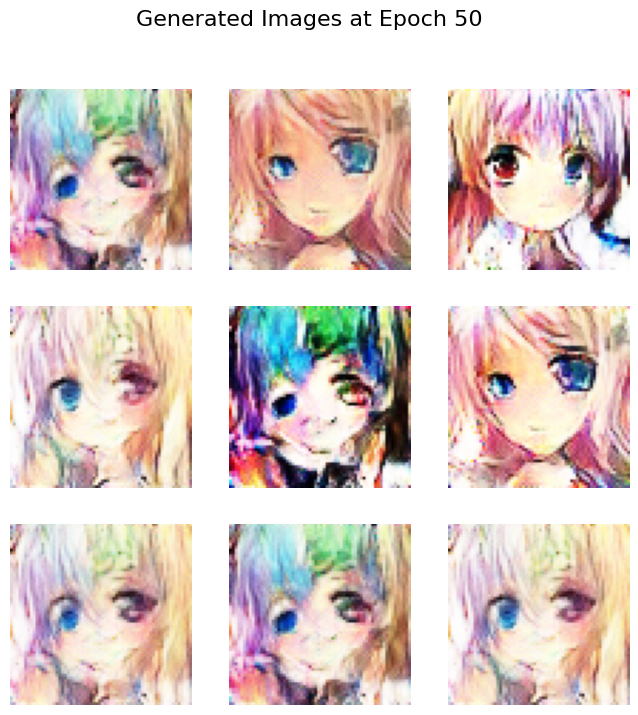

Epoch [51/100], D Loss: 0.020779550075531006, G Loss: 5.039860248565674
Epoch [52/100], D Loss: 0.12480580061674118, G Loss: 3.6923234462738037
Epoch [53/100], D Loss: 0.012092729099094868, G Loss: 7.763293266296387
Epoch [54/100], D Loss: 0.06896895170211792, G Loss: 4.725375175476074
Epoch [55/100], D Loss: 0.03014063835144043, G Loss: 5.723388671875
Epoch [56/100], D Loss: 0.08736899495124817, G Loss: 3.690307140350342
Epoch [57/100], D Loss: 0.30878886580467224, G Loss: 5.13007116317749
Epoch [58/100], D Loss: 0.23036572337150574, G Loss: 4.156219482421875
Epoch [59/100], D Loss: 0.006160615012049675, G Loss: 5.018387317657471
Epoch [60/100], D Loss: 0.03880186006426811, G Loss: 4.701574802398682


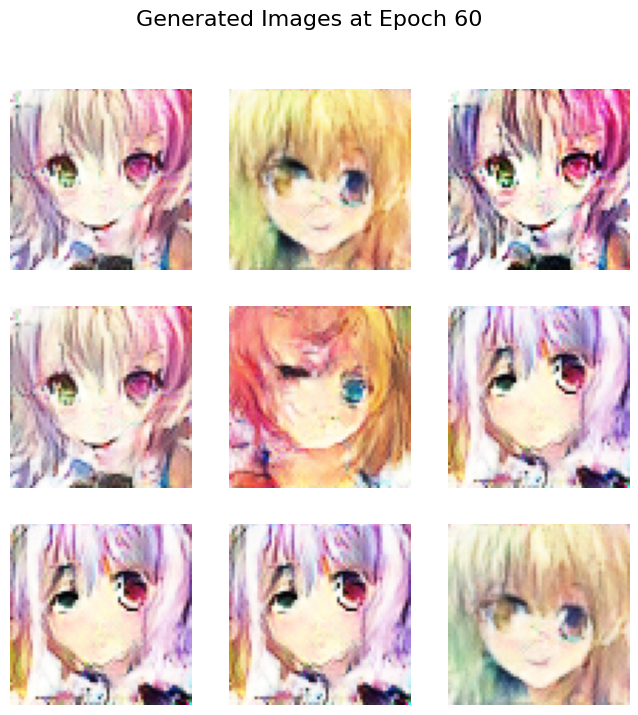

Epoch [61/100], D Loss: 0.10413774847984314, G Loss: 4.4990620613098145
Epoch [62/100], D Loss: 0.10304717719554901, G Loss: 5.780735492706299
Epoch [63/100], D Loss: 0.07576862722635269, G Loss: 5.115108013153076
Epoch [64/100], D Loss: 0.0791582316160202, G Loss: 8.152363777160645
Epoch [65/100], D Loss: 0.012417422607541084, G Loss: 6.908168315887451
Epoch [66/100], D Loss: 0.012451130896806717, G Loss: 7.843115329742432
Epoch [67/100], D Loss: 0.0036636728327721357, G Loss: 7.409794330596924
Epoch [68/100], D Loss: 0.08672453463077545, G Loss: 9.876670837402344
Epoch [69/100], D Loss: 0.018275754526257515, G Loss: 6.0604777336120605
Epoch [70/100], D Loss: 0.0010946067050099373, G Loss: 10.498710632324219


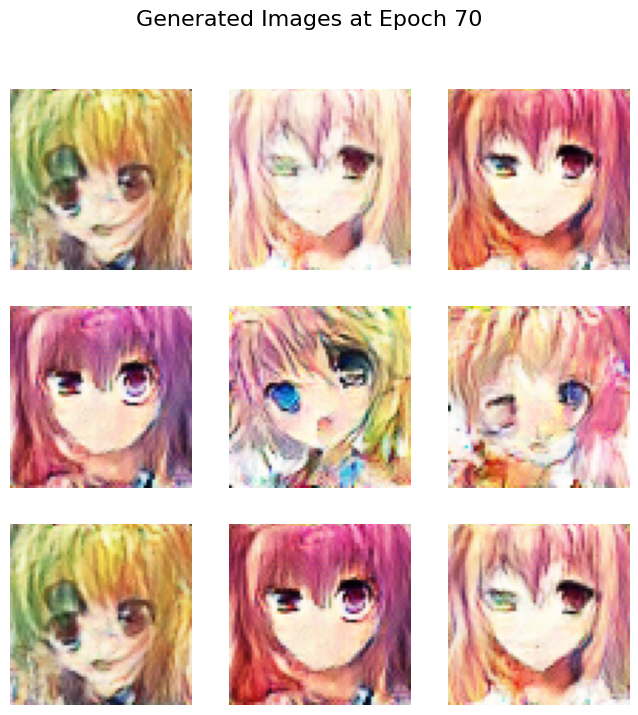

Epoch [71/100], D Loss: 0.17892564833164215, G Loss: 2.9756667613983154
Epoch [72/100], D Loss: 0.02249055914580822, G Loss: 5.0944294929504395
Epoch [73/100], D Loss: 0.0009127063094638288, G Loss: 9.094626426696777
Epoch [74/100], D Loss: 0.1887916475534439, G Loss: 7.166606903076172
Epoch [75/100], D Loss: 0.04684709012508392, G Loss: 5.693597316741943
Epoch [76/100], D Loss: 0.24039524793624878, G Loss: 7.860136032104492
Epoch [77/100], D Loss: 0.006800178438425064, G Loss: 6.258777141571045
Epoch [78/100], D Loss: 0.022668899968266487, G Loss: 7.003223896026611
Epoch [79/100], D Loss: 0.011703616939485073, G Loss: 6.68359375
Epoch [80/100], D Loss: 0.07769775390625, G Loss: 6.725629806518555


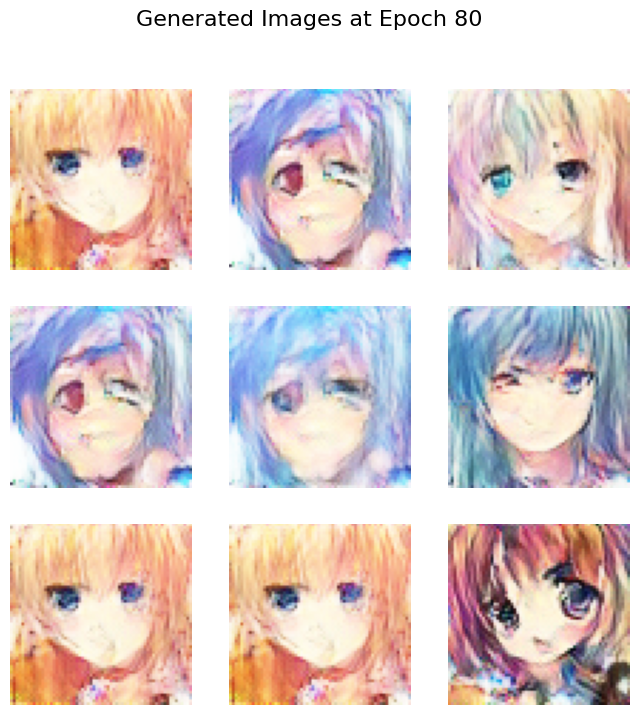

Epoch [81/100], D Loss: 0.008865104988217354, G Loss: 6.446377277374268
Epoch [82/100], D Loss: 0.32303762435913086, G Loss: 8.832324028015137
Epoch [83/100], D Loss: 0.13182930648326874, G Loss: 4.071714401245117
Epoch [84/100], D Loss: 0.2988552153110504, G Loss: 2.5342297554016113
Epoch [85/100], D Loss: 0.10231590270996094, G Loss: 6.973392486572266
Epoch [86/100], D Loss: 0.08901728689670563, G Loss: 4.014825820922852
Epoch [87/100], D Loss: 0.002869613002985716, G Loss: 7.5654988288879395
Epoch [88/100], D Loss: 0.0012959962477907538, G Loss: 7.849033355712891
Epoch [89/100], D Loss: 0.022694766521453857, G Loss: 7.523654460906982
Epoch [90/100], D Loss: 0.016122838482260704, G Loss: 6.88578987121582


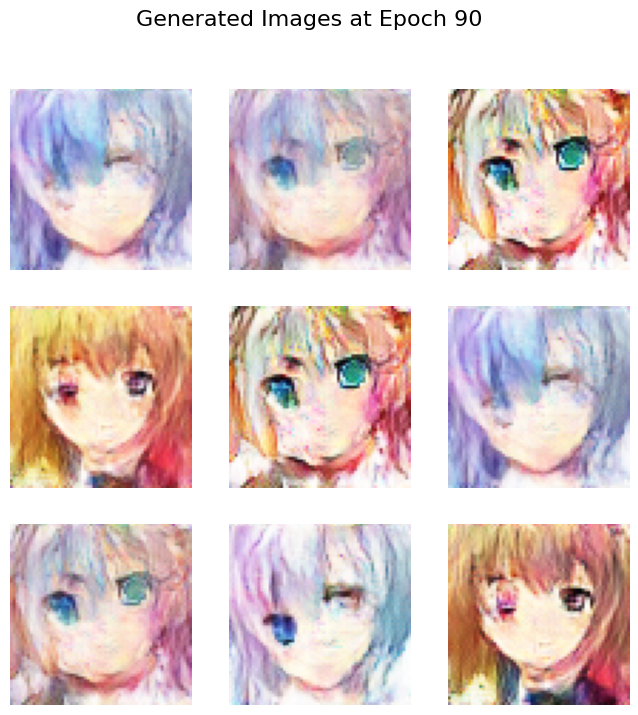

Epoch [91/100], D Loss: 0.08932638168334961, G Loss: 6.691280841827393
Epoch [92/100], D Loss: 0.028832275420427322, G Loss: 6.552556991577148
Epoch [93/100], D Loss: 0.017696870490908623, G Loss: 6.017552852630615
Epoch [94/100], D Loss: 0.12922246754169464, G Loss: 6.041093826293945
Epoch [95/100], D Loss: 0.46737557649612427, G Loss: 4.133091449737549
Epoch [96/100], D Loss: 0.13357417285442352, G Loss: 3.5632238388061523
Epoch [97/100], D Loss: 0.0027866100426763296, G Loss: 7.1913018226623535
Epoch [98/100], D Loss: 0.04333711415529251, G Loss: 8.008913040161133
Epoch [99/100], D Loss: 0.06737900525331497, G Loss: 6.823128700256348


In [8]:
num_epochs = 100
train_gan(num_epochs, dataloader, generator, discriminator, optimizer_G, optimizer_D, criterion, device)

In [9]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')